Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (42).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  

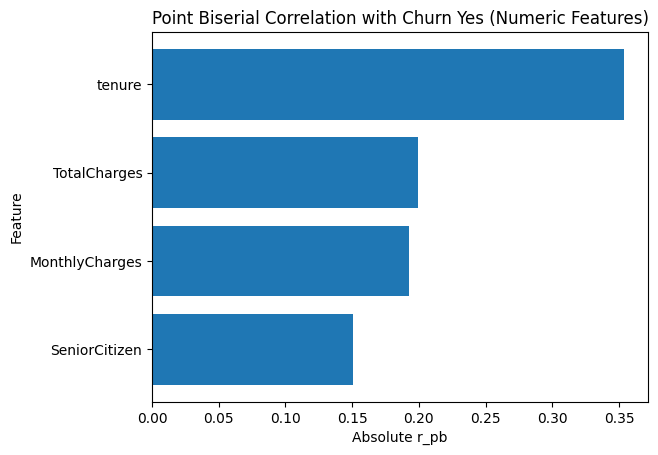

Accuracy : 0.8038379530916845
Precision: 0.6475903614457831
Recall   : 0.5748663101604278
F1-score : 0.6090651558073654
ROC-AUC  : 0.7308019837346185
Confusion Matrix:
 [[916 117]
 [159 215]]
Random Forest Result:
Accuracy: 0.7896233120113717
Precision: 0.6258064516129033
Recall: 0.5187165775401069
F1: 0.5672514619883041
ROC AUC Score: 0.703211144529976
Confusion Matrix: [[917 116]
 [180 194]]
XGBoost Result:
Accuracy: 0.7782515991471215
Precision: 0.5890804597701149
Recall: 0.5481283422459893
F1: 0.5678670360110804
ROC AUC Score: 0.7048482950339336
Confusion Matrix:
 [[890 143]
 [169 205]]
Tuned Logistic Regression Result:
Accuracy : 0.7263681592039801
Precision: 0.49093904448105435
Recall   : 0.7967914438502673
F1-score : 0.6075433231396534
ROC-AUC  : 0.7488313463200998
Confusion Matrix:
 [[724 309]
 [ 76 298]]
Tuned Random Forest Result:
Accuracy : 0.7668798862828714
Precision: 0.5444015444015444
Recall   : 0.7540106951871658
F1-score : 0.6322869955156951
ROC-AUC  : 0.76277495069135

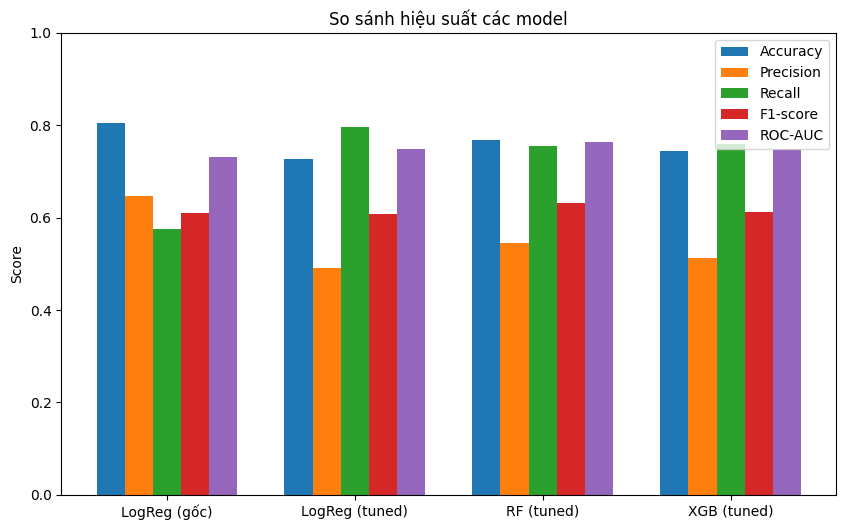

In [49]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()
df.info()
df.shape
df.isnull().sum()

# Vì biến TotalCharge nhìn sơ trong dataset là dạng số nhưng ở đây Dtype là Object nên ta cần tìm hiểu nguyên nhân & xử lý
df['TotalCharges'].unique()
# Vì Có thể có một số giá trị chuỗi trắng (' '), chuỗi rỗng hoặc khoảng trắng mà .unique() chưa hiện rõ vì số lượng giá trị rất lớn (7043 dòng) nên tìm hướng khác
import numpy as np
df['TotalCharges'] = df['TotalCharges'].str.strip().replace("", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].isnull().sum()
df.info()

# Giờ tìm các cột có Dtype là Object để chuyển hóa thành one-hot encoding
categorical_cols = df.select_dtypes(include = 'object').columns.tolist()
categorical_cols.remove('customerID')
for col in categorical_cols:
  print(col)
  print(df[col].nunique())

# Sau khi biết các cột có Dtype object này chỉ có dưới 4 category --> tha hồ xài one hot encoding
df_encoded = pd.get_dummies(df, columns = categorical_cols, drop_first=True)
df_encoded.shape
df_encoded.info()

# Loại biến customerID vì thường không dùng trong phân tích dự đoán vì nó không chứa thông tin giúp phân loại khách hàng
df_encoded = df_encoded.drop('customerID', axis = 1)
df_encoded.columns
df_encoded['Churn_Yes'].value_counts(dropna=False)

# Trước khi tính point biserial, ta cần đổi True → 1 và False → 0 để tính toán thuận tiện
df_encoded['Churn_Yes'] = df_encoded['Churn_Yes'].astype(int)

# Kiểm tra Monthly Charges xem có thiếu giá trị nào không, nếu có phải xử lý mới đi tiếp được
df['MonthlyCharges'].isna().sum()

# Giờ Tính point biserial cho MonthlyCharges ↔ Churn_Yes
from scipy.stats import pointbiserialr
r, p = pointbiserialr(df_encoded['Churn_Yes'], df['MonthlyCharges'])
print("r_pb =", r, "| p value =", p)

# Do kết quả trên, mức ảnh hưởng chỉ ở mức nhẹ, cần xem xét các biến khác. Giờ đến Tenure
r, p = pointbiserialr(df_encoded['Churn_Yes'], df_encoded['tenure'])
print("r_pb =", r, "| p value =", p)

# Giờ đến Total Charges
df['TotalCharges'].isna().sum()
df_encoded = df_encoded.dropna(subset=['TotalCharges'])
r, p = pointbiserialr(df_encoded['Churn_Yes'], df_encoded['TotalCharges'])
print("r_pb =", r, "| p value =", p)

# Lọc ra tất cả các cột có kiểu dữ liệu là số (numeric)
df_encoded.select_dtypes(include=[np.number]).columns
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Giờ Tính point biserial cho từng cột trong num_cols
result = []
for col in num_cols:
  mask = df_encoded[col].notna() & df_encoded['Churn_Yes'].notna()
  r, p = pointbiserialr(df_encoded.loc[mask, 'Churn_Yes'], df_encoded.loc[mask, col])
  result.append((col, r, p))
result

# Chuyển list kết quả thành bảng & xếp hạng
pb_df = pd.DataFrame(result, columns=['feature', 'r_pb', 'p value'])
pb_df['abs_r'] = pb_df['r_pb'].abs()
pb_df = pb_df.sort_values('abs_r', ascending=False)

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.barh(pb_df['feature'], pb_df['abs_r'])
plt.xlabel('Absolute r_pb')
plt.ylabel('Feature')
plt.title('Point Biserial Correlation with Churn Yes (Numeric Features)')
plt.gca().invert_yaxis()
plt.show()

# Nãy là numeric features, giờ quất luôn phân tích categorical features.
cat_cols = df_encoded.select_dtypes(exclude=[np.number]).columns
cat_cols
import scipy.stats as ss
import numpy as np
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x, y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  return np.sqrt(phi2 / (min(k - 1, r - 1)))
result_cat = []
for col in cat_cols:
  r = cramers_v(df_encoded['Churn_Yes'], df_encoded[col])
  result_cat.append((col, r))
cat_df = pd.DataFrame(result_cat, columns=['feature', 'cramers_v'])
cat_df = cat_df.sort_values('cramers_v', ascending=False)
cat_df

# Gộp hai bảng ranking này thành Feature Priority List
num_df = pd.DataFrame(result, columns=['feature', 'score', 'p value'])
num_df['abs_score'] = num_df['score'].abs()
num_df['type'] = 'numeric'
cat_df = pd.DataFrame(result_cat, columns=['feature', 'score'])
cat_df['abs_score'] = cat_df['score'].abs()
cat_df['type'] = 'categorical'
all_features_df = pd.concat([num_df[['feature', 'score', 'abs_score', 'type']], cat_df[['feature', 'score', 'abs_score', 'type']]], ignore_index=True)
all_features_df = all_features_df.sort_values('abs_score', ascending=False)
all_features_df

# Giờ chạy mô hình
y = df_encoded['Churn_Yes']
X = df_encoded.drop(columns=['Churn_Yes'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=2000, solver='saga')
log_reg.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
y_pred = log_reg.predict(X_test_scaled)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Chuyển qua Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Result:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_rf))

# Chuyển qua XG Boost do Logistics Regression vẫn đang hơn Random Forest
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Result:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

#Tuning Logistics Regression do nó vẫn thắng 2 model kia
from sklearn.linear_model import LogisticRegression
log_reg_tuned = LogisticRegression(
    max_iter=3000,
    solver='saga',
    class_weight='balanced',
    C=2.0,
    random_state=42
)
log_reg_tuned.fit(X_train_scaled, y_train)
y_pred_tuned = log_reg_tuned.predict(X_test_scaled)
print("Tuned Logistic Regression Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall   :", recall_score(y_test, y_pred_tuned))
print("F1-score :", f1_score(y_test, y_pred_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# Tuning Random Forest do Logistics Regression tuning xong còn dở hơn cái gốc
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
print("Tuned Random Forest Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf_tuned))
print("Precision:", precision_score(y_test, y_pred_rf_tuned))
print("Recall   :", recall_score(y_test, y_pred_rf_tuned))
print("F1-score :", f1_score(y_test, y_pred_rf_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_rf_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))

# Tuning XGBoost luôn
from xgboost import XGBClassifier

xgb_tuned = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    eval_metric='logloss'
)

xgb_tuned.fit(X_train, y_train)

y_pred_xgb_tuned = xgb_tuned.predict(X_test)

print("Tuned XGBoost Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb_tuned))
print("Precision:", precision_score(y_test, y_pred_xgb_tuned))
print("Recall   :", recall_score(y_test, y_pred_xgb_tuned))
print("F1-score :", f1_score(y_test, y_pred_xgb_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_xgb_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))

# Vẽ biểu đồ trực quan
import matplotlib.pyplot as plt
import numpy as np

# Tên model và các chỉ số
models = ['LogReg (gốc)', 'LogReg (tuned)', 'RF (tuned)', 'XGB (tuned)']
accuracy = [0.8038, 0.7264, 0.7669, 0.7441]
precision = [0.6476, 0.4909, 0.5444, 0.5126]
recall = [0.5749, 0.7968, 0.7540, 0.7594]
f1 = [0.6091, 0.6075, 0.6323, 0.6121]
roc_auc = [0.7308, 0.7488, 0.7628, 0.7490]

x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 2*width, accuracy, width, label='Accuracy')
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-score')
ax.bar(x + 2*width, roc_auc, width, label='ROC-AUC')

ax.set_ylabel('Score')
ax.set_title('So sánh hiệu suất các model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)
plt.show()